# 07__motif_coverage
# analyzing how motif coverage correlates with MPRA properties and biotypes; clustering similar motifs

in this notebook, i look at how the coverage metrics (# bp covered and max coverage of motifs; done separately, see methods) look within biotypes *after* limiting to only those motifs which have been validated by a corresponding chip peak. i also make sure the results we see aren't due to redundancies in motif databases, so i cluster the motifs using MoSBAT (done separately using their webtool) and re-calculate the metrics.

------

figures in this notebook:
- **Fig 2D and 2E**: cumulative density plots of # bp covered and max motif coverage across biotypes
- **Fig S7**: heatmap of clustered motifs, and more cumulative density plots (after clustering)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from random import shuffle
from scipy import stats
from scipy import signal
from scipy.spatial import distance
from scipy.cluster import hierarchy
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
mosbat_file = "../../misc/02__mosbat/results.from_mosbat.txt"

In [4]:
all_tss_f = "../../data/00__index/0__all_tss/All.TSS.114bp.bed"
motif_cov_f = "../../misc/03__fimo/All.TSS.114bp.Motifs.txt"
motif_max_f = "../../misc/03__fimo/All.TSS.114bp.maxonly.txt"
chip_cov_f = "../../misc/03__fimo/All.TSS.114bp.Motifs.Intersect.Chip.ALL.txt"
cluster_cov_f = "../../misc/03__fimo/All.TSS.114bp.Cluster.ALL.txt"
cage_expr_f = "../../misc/other_files/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt"

note: the reason why some IDs are not in the expression file is these are FANTOM CAT IDs that for some reason are not present in the FANTOM5 robust set. so, we exclude these.

## 1. import data

In [5]:
corr = pd.read_table(mosbat_file, sep="\t")

In [6]:
all_tss = pd.read_table(all_tss_f, sep="\t", header=None)
all_tss.columns = ["chr", "start", "end", "seqID", "score", "strand"]
all_tss = all_tss.drop_duplicates()
print(len(all_tss))
print(len(all_tss["seqID"].unique()))
all_tss.head()

56630
56630


,chr,start,end,seqID,score,strand
0,chr1,10003350,10003465,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-
1,chr1,10003452,10003567,protein_coding__p1@NMNAT1__chr1:10003486..1000...,0,+
2,chr1,100111588,100111703,protein_coding__p1@PALMD__chr1:100111580..1001...,0,+
3,chr1,100232148,100232263,protein_coding__p1@FRRS1__chr1:100232177..1002...,0,-
4,chr1,100315601,100315716,protein_coding__p1@AGL__chr1:100315613..100315...,0,+


In [7]:
motif_cov = pd.read_table(motif_cov_f, sep="\t")
motif_cov = motif_cov.drop_duplicates()
motif_max = pd.read_table(motif_max_f, sep="\t", header=None)
motif_max = motif_max.drop_duplicates()
motif_max.columns = ["seqID", "MaxCov"]

# get promtype2
motif_cov["PromType2"] = motif_cov.seqID.str.split("__", expand=True)[0]


# merge w/ All_TSS to get 0s
motif_cov = all_tss[["seqID"]].merge(motif_cov, on="seqID", how="left")
motif_cov = motif_cov.merge(motif_max, on="seqID", how="left")
motif_cov.fillna(0, inplace=True)
print(len(motif_cov))

# get promtype2
motif_cov["PromType2"] = motif_cov.seqID.str.split("__", expand=True)[0]


motif_cov.sample(5)

56630


,seqID,numMotifs,numBPcovered,fragmentLength,fractionBPcovered,PromType2,MaxCov
14753,protein_coding__p2@CYP27A1__chr2:219646462..21...,27,83,115,0.721739,protein_coding,13
31165,Enhancer__chr11:10948023-10948274,18,52,115,0.452174,Enhancer,12
47202,Enhancer__chr4:38213511-38213757,23,54,115,0.469565,Enhancer,7
4489,"protein_coding__p1@OR51B5,p2@HBE1__chr11:55268...",8,48,115,0.417391,protein_coding,4
31306,Enhancer__chr11:118691289-118691413,36,64,115,0.556522,Enhancer,23


In [8]:
chip_cov = pd.read_table(chip_cov_f, sep="\t")
chip_cov = chip_cov.drop_duplicates()

# get promtype2
chip_cov["PromType2"] = chip_cov.seqID.str.split("__", expand=True)[0]

# merge w/ All_TSS to get 0s
chip_cov = all_tss[["seqID"]].merge(chip_cov, on="seqID", how="left")
chip_cov.fillna(0, inplace=True)
print(len(chip_cov))

# get promtype2
chip_cov["PromType2"] = chip_cov.seqID.str.split("__", expand=True)[0]


chip_cov.sample(5)

56630


,seqID,PromType2,TSS_id,numMotifs,numBPcovered,fragmentLength,fractionBPcovered,MaxCov
49697,Enhancer__chr6:121940262-121940519,Enhancer,chr6:121940262-121940519,0.0,0.0,115.0,0.000000,0.0
18614,"protein_coding__NA__chr3:52321065..52321072,+",protein_coding,0,0.0,0.0,0.0,0.000000,0.0
8155,protein_coding__p4@MEIS2__chr15:37393449..3739...,protein_coding,"p4@MEIS2__chr15:37393449..37393528,-",2.0,13.0,115.0,0.113043,2.0
7859,protein_coding__p3@AHSA1__chr14:77924204..7792...,protein_coding,"p3@AHSA1__chr14:77924204..77924229,+",2.0,17.0,115.0,0.147826,2.0
48017,Enhancer__chr5:141151294-141151412,Enhancer,chr5:141151294-141151412,0.0,0.0,115.0,0.000000,0.0


In [9]:
def fix_enh_seqid(row):
    if "Enhancer" in row.seqID:
        if "NA" in row.seqID:
            new_id = row.seqID.split("__")[0] + "__" + row.seqID.split("__")[2]
            return new_id
        else:
            return row.seqID
    else:
        return row.seqID

In [10]:
cluster_cov = pd.read_table(cluster_cov_f, sep="\t")
cluster_cov = cluster_cov.drop_duplicates()

# get promtype2
cluster_cov["PromType2"] = cluster_cov.seqID.str.split("__", expand=True)[0]
cluster_cov["seqID"] = cluster_cov.apply(fix_enh_seqid, axis=1)

# # merge w/ All_TSS to get 0s
cluster_cov = all_tss[["seqID"]].merge(cluster_cov, on="seqID", how="left")
cluster_cov.fillna(0, inplace=True)
print(len(cluster_cov))

# get promtype2
cluster_cov["PromType2"] = cluster_cov.seqID.str.split("__", expand=True)[0]

cluster_cov.sample(5)

56630


,seqID,numMotifs,numBPcovered,fragmentLength,fractionBPcovered,PromType2,MaxCov
34320,Enhancer__chr13:44818555-44818615,9,47,115,0.408696,Enhancer,4
51449,Enhancer__chr6:81219301-81219687,15,71,115,0.617391,Enhancer,7
33233,Enhancer__chr12:59478697-59478823,7,65,115,0.565217,Enhancer,4
51526,Enhancer__chr6:87727434-87727816,14,65,115,0.565217,Enhancer,5
19086,protein_coding__p1@NAA15__chr4:140222640..1402...,16,81,115,0.704348,protein_coding,4


In [11]:
# filter to those that have at least 1 motif so distributions are not 0-skewed
motif_cov = motif_cov[motif_cov["numMotifs"] > 0]
print(len(motif_cov))

chip_cov = chip_cov[chip_cov["numMotifs"] > 0]
print(len(chip_cov))

cluster_cov = cluster_cov[cluster_cov["numMotifs"] > 0]
print(len(cluster_cov))

56578
21685
56530


In [12]:
cage_expr = pd.read_table(cage_expr_f, sep="\t")
cage_expr.head()

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"chr10:100013403..100013414,-",0.023403,0.993829,0.666667,38,tissue-specific
1,"chr10:100027943..100027958,-",5.375834,0.968756,0.666667,346,ubiquitous
2,"chr10:100076685..100076699,+",0.012479,0.984646,NaN,34,tissue-specific
3,"chr10:100150910..100150935,-",0.155925,0.991970,NaN,80,tissue-specific
4,"chr10:100150951..100150962,-",0.038083,0.981522,NaN,49,tissue-specific


In [13]:
def get_cage_id(row):
    split = row.seqID.split("__")
    if len(split) == 2:
        return split[1]
    else:
        return split[2]

In [14]:
motif_cov["cage_id"] = motif_cov.apply(get_cage_id, axis=1)
motif_cov = motif_cov.merge(cage_expr, on="cage_id", how="left")
motif_cov.head()

,seqID,numMotifs,numBPcovered,fragmentLength,fractionBPcovered,PromType2,MaxCov,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"div_pc__p1@LZIC__chr1:10003372..10003465,-",120,72,115,0.626087,div_pc,40,"chr1:10003372..10003465,-",16.729904,0.737084,0.144850,550.0,ubiquitous
1,protein_coding__p1@NMNAT1__chr1:10003486..1000...,70,84,115,0.730435,protein_coding,42,"chr1:10003486..10003551,+",9.250405,0.696002,0.183070,547.0,ubiquitous
2,protein_coding__p1@PALMD__chr1:100111580..1001...,7,57,115,0.495652,protein_coding,3,"chr1:100111580..100111773,+",21.288713,0.951141,0.456065,369.0,ubiquitous
3,protein_coding__p1@FRRS1__chr1:100232177..1002...,37,68,115,0.591304,protein_coding,26,"chr1:100232177..100232198,-",3.219975,0.896179,0.528074,508.0,ubiquitous
4,protein_coding__p1@AGL__chr1:100315613..100315...,41,107,115,0.930435,protein_coding,22,"chr1:100315613..100315691,+",12.478584,0.858348,0.309695,549.0,ubiquitous


In [15]:
chip_cov["cage_id"] = chip_cov.apply(get_cage_id, axis=1)
chip_cov = chip_cov.merge(cage_expr, on="cage_id", how="left")
chip_cov.sample(10)

,seqID,PromType2,TSS_id,numMotifs,numBPcovered,fragmentLength,fractionBPcovered,MaxCov,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
14387,Enhancer__chr14:65601506-65601634,Enhancer,chr14:65601506-65601634,2.0,16.0,115.0,0.139130,2.0,chr14:65601506-65601634,0.039276,0.992238,NaN,30,tissue-specific
7836,"div_pc__p2@PPP1R2__chr3:195270162..195270181,-",div_pc,"p2@PPP1R2__chr3:195270162..195270181,-",3.0,37.0,115.0,0.321739,2.0,"chr3:195270162..195270181,-",4.149850,0.783778,0.108426,542,ubiquitous
20134,Enhancer__chr7:131583321-131583576,Enhancer,chr7:131583321-131583576,2.0,21.0,115.0,0.182609,1.0,chr7:131583321-131583576,0.016265,0.986367,NaN,39,tissue-specific
21025,Enhancer__chr8:95246535-95247070,Enhancer,chr8:95246535-95247070,1.0,11.0,115.0,0.095652,1.0,chr8:95246535-95247070,0.127511,0.991667,0.666667,139,tissue-specific
9789,protein_coding__p2@SYPL1__chr7:105752971..1057...,protein_coding,"p2@SYPL1__chr7:105752971..105753054,-",6.0,40.0,115.0,0.347826,4.0,"chr7:105752971..105753054,-",0.853942,0.990542,0.324049,459,ubiquitous
2893,intergenic__p1@ENST00000546259__chr12:9800544....,intergenic,"p1@ENST00000546259__chr12:9800544..9800592,-",5.0,47.0,115.0,0.408696,2.0,"chr12:9800544..9800592,-",0.149570,0.988507,0.280253,217,tissue-specific
6293,"div_pc__p1@ORC2__chr2:201828356..201828412,-",div_pc,"p1@ORC2__chr2:201828356..201828412,-",7.0,29.0,115.0,0.252174,5.0,"chr2:201828356..201828412,-",25.090366,0.658134,0.396422,549,ubiquitous
12333,Enhancer__chr1:54925355-54925634,Enhancer,chr1:54925355-54925634,1.0,11.0,115.0,0.095652,1.0,chr1:54925355-54925634,0.020813,0.991472,NaN,29,tissue-specific
5203,protein_coding__p2@KANK2__chr19:11308502..1130...,protein_coding,"p2@KANK2__chr19:11308502..11308553,-",2.0,17.0,115.0,0.147826,2.0,"chr19:11308502..11308553,-",1.329308,0.958463,0.206725,461,ubiquitous
19528,Enhancer__chr6:14921244-14921932,Enhancer,chr6:14921244-14921932,1.0,14.0,115.0,0.121739,1.0,chr6:14921244-14921932,0.182678,0.994213,NaN,74,tissue-specific


In [16]:
cluster_cov["cage_id"] = cluster_cov.apply(get_cage_id, axis=1)
cluster_cov = cluster_cov.merge(cage_expr, on="cage_id", how="left")
cluster_cov.head()

,seqID,numMotifs,numBPcovered,fragmentLength,fractionBPcovered,PromType2,MaxCov,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"div_pc__p1@LZIC__chr1:10003372..10003465,-",9,72,115,0.626087,div_pc,3,"chr1:10003372..10003465,-",16.729904,0.737084,0.144850,550.0,ubiquitous
1,protein_coding__p1@NMNAT1__chr1:10003486..1000...,10,67,115,0.582609,protein_coding,3,"chr1:10003486..10003551,+",9.250405,0.696002,0.183070,547.0,ubiquitous
2,protein_coding__p1@PALMD__chr1:100111580..1001...,5,44,115,0.382609,protein_coding,2,"chr1:100111580..100111773,+",21.288713,0.951141,0.456065,369.0,ubiquitous
3,protein_coding__p1@FRRS1__chr1:100232177..1002...,9,58,115,0.504348,protein_coding,5,"chr1:100232177..100232198,-",3.219975,0.896179,0.528074,508.0,ubiquitous
4,protein_coding__p1@AGL__chr1:100315613..100315...,15,107,115,0.930435,protein_coding,6,"chr1:100315613..100315691,+",12.478584,0.858348,0.309695,549.0,ubiquitous


In [17]:
chip_cov_exp = chip_cov[~pd.isnull(chip_cov["av_exp"])]
motif_cov_exp = motif_cov[~pd.isnull(motif_cov["av_exp"])]
cluster_cov_exp = cluster_cov[~pd.isnull(cluster_cov["av_exp"])]

In [18]:
motif_cov_exp.PromType2.value_counts()

Enhancer          29771
protein_coding    13441
intergenic         1531
div_pc             1302
div_lnc             674
antisense           622
Name: PromType2, dtype: int64

In [19]:
chip_cov_exp.PromType2.value_counts()

Enhancer          10199
protein_coding     9023
div_pc             1039
intergenic          632
div_lnc             533
antisense           259
Name: PromType2, dtype: int64

In [20]:
cluster_cov_exp.PromType2.value_counts()

Enhancer          29739
protein_coding    13436
intergenic         1531
div_pc             1300
div_lnc             674
antisense           621
Name: PromType2, dtype: int64

## 2. plot # bp covered & max cov across biotypes

### all motifs

In [21]:
motif_cov["log_bp_covered"] = np.log(motif_cov["numBPcovered"]+1)
motif_cov["log_max_cov"] = np.log(motif_cov["MaxCov"]+1)

motif_cov_exp["log_bp_covered"] = np.log(motif_cov_exp["numBPcovered"]+1)
motif_cov_exp["log_max_cov"] = np.log(motif_cov_exp["MaxCov"]+1)

(2, 5)

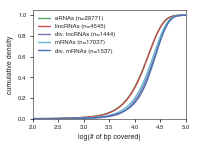

In [22]:
enh_vals = motif_cov[motif_cov["PromType2"] == "Enhancer"]["log_bp_covered"]
linc_vals = motif_cov[motif_cov["PromType2"] == "intergenic"]["log_bp_covered"]
dlnc_vals = motif_cov[motif_cov["PromType2"] == "div_lnc"]["log_bp_covered"]
pc_vals = motif_cov[motif_cov["PromType2"] == "protein_coding"]["log_bp_covered"]
dpc_vals = motif_cov[motif_cov["PromType2"] == "div_pc"]["log_bp_covered"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
ax.set_xlim((2, 5))

i: 0, promtype: Enhancer, name: eRNAs
i: 1, promtype: intergenic, name: lincRNAs
i: 2, promtype: protein_coding, name: mRNAs


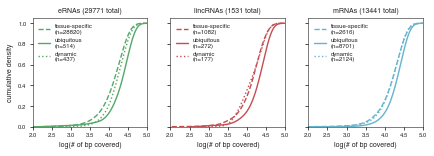

In [23]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = motif_cov_exp
col = "log_bp_covered"
xlabel = "log(# of bp covered)"
xlim = (2, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-specific\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiquitous\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="upper left")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")

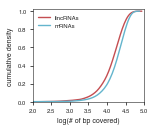

In [24]:
fig = plt.figure(figsize=(2, 1.7))
ax = sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
                 label="lincRNAs")
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
ax.set_xlim((2, 5))
ax.set_ylim((0, 1.02))
fig.savefig("num_bp_cov.cdf.for_talk.pdf", dpi="figure", bbox_inches="tight")

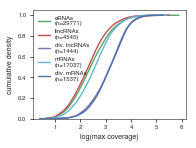

In [25]:
enh_vals = motif_cov[motif_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = motif_cov[motif_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = motif_cov[motif_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = motif_cov[motif_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = motif_cov[motif_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
ax.legend(loc="upper left")
fig.savefig("max_cov.all_biotypes.for_poster.pdf", dpi="figure", bbox_inches="tight")

i: 0, promtype: Enhancer, name: eRNAs
i: 1, promtype: intergenic, name: lincRNAs
i: 2, promtype: protein_coding, name: mRNAs


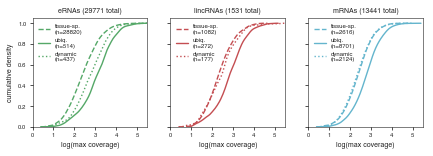

In [26]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = motif_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (0, 5.5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")

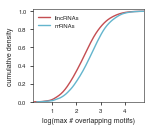

In [27]:
fig = plt.figure(figsize=(2, 1.7))
ax = sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
                 label="lincRNAs")
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
ax.set_xlabel("log(max # overlapping motifs)")
ax.set_ylabel("cumulative density")
ax.set_xlim((0.2, 4.8))
ax.set_ylim((0, 1.02))
plt.legend(loc=2)
fig.savefig("max_cov.cdf.for_talk.pdf", dpi="figure", bbox_inches="tight")

### ChIP-validated motifs

In [28]:
chip_cov["log_bp_covered"] = np.log(chip_cov["numBPcovered"]+1)
chip_cov["log_max_cov"] = np.log(chip_cov["MaxCov"]+1)

chip_cov_exp["log_bp_covered"] = np.log(chip_cov_exp["numBPcovered"]+1)
chip_cov_exp["log_max_cov"] = np.log(chip_cov_exp["MaxCov"]+1)

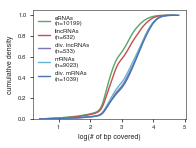

In [29]:
enh_vals = chip_cov[chip_cov["PromType2"] == "Enhancer"]["log_bp_covered"]
linc_vals = chip_cov[chip_cov["PromType2"] == "intergenic"]["log_bp_covered"]
dlnc_vals = chip_cov[chip_cov["PromType2"] == "div_lnc"]["log_bp_covered"]
pc_vals = chip_cov[chip_cov["PromType2"] == "protein_coding"]["log_bp_covered"]
dpc_vals = chip_cov[chip_cov["PromType2"] == "div_pc"]["log_bp_covered"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_2D.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
i: 1, promtype: intergenic, name: lincRNAs
i: 2, promtype: protein_coding, name: mRNAs


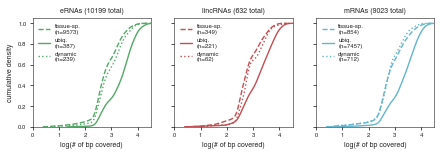

In [30]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = chip_cov_exp
col = "log_bp_covered"
xlabel = "log(# of bp covered)"
xlim = (0, 4.5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_2D_biotype_split.pdf", bbox_inches="tight", dpi="figure")

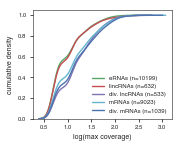

In [31]:
enh_vals = chip_cov[chip_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = chip_cov[chip_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = chip_cov[chip_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = chip_cov[chip_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = chip_cov[chip_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.5, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_2E.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
i: 1, promtype: intergenic, name: lincRNAs
i: 2, promtype: protein_coding, name: mRNAs


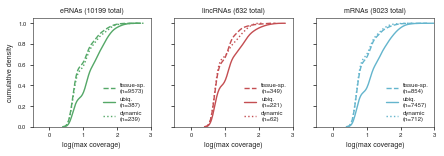

In [32]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = chip_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (-0.5, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_2E_biotype_split.pdf", bbox_inches="tight", dpi="figure")

## 2. cluster the motifs using MoSBAT output

In [33]:
corr.set_index(corr["Motif"], inplace=True)
corr.drop("Motif", axis=1, inplace=True)
corr.head()

,RUNX1,TFAP2A,Arnt,Ahr..Arnt,Ar,T,PAX5,NR2F1,CREB1,Ddit3..Cebpa,...,HOXC12,HOXC13,HOXD11,HOXD13,Hoxd8,Hoxa11,Hoxd3,Hoxd9,ISL2,Hes1
Motif,,,,,,,,,,,,,,,,,,,,,
RUNX1,1.000000,0.053362,-0.045079,0.084369,-0.044827,-0.011180,0.009678,0.023699,0.031270,-0.042494,...,-0.046124,-0.054724,-0.089790,-0.021027,-0.038859,-0.082215,0.014631,-0.013418,0.029031,-0.012669
TFAP2A,0.053362,1.000000,0.060590,0.040435,0.008935,-0.033231,0.083051,0.072317,0.036212,0.012966,...,-0.142886,-0.121405,-0.172917,-0.117810,-0.184969,-0.147377,-0.089514,-0.148299,-0.072275,0.146438
Arnt,-0.045079,0.060590,1.000000,0.355305,0.065284,0.121252,-0.006139,0.048724,0.153955,0.042929,...,-0.020919,-0.022952,-0.059050,-0.077210,-0.123874,-0.067242,-0.082448,-0.073004,-0.047794,0.694827
Ahr..Arnt,0.084369,0.040435,0.355305,1.000000,0.040715,0.127365,0.061560,-0.000861,0.066961,0.022640,...,-0.027722,-0.025836,-0.058218,-0.043445,-0.090282,-0.037421,-0.068454,-0.048630,-0.033096,0.441696
Ar,-0.044827,0.008935,0.065284,0.040715,1.000000,-0.031151,-0.056479,-0.006634,0.013517,0.005174,...,-0.013779,-0.011751,-0.022109,-0.054133,-0.060648,-0.024212,0.004521,-0.034178,0.023124,0.081356


In [34]:
row_linkage = hierarchy.linkage(distance.pdist(corr, 'correlation'), method="average")
col_linkage = hierarchy.linkage(distance.pdist(corr.T, 'correlation'), method="average")

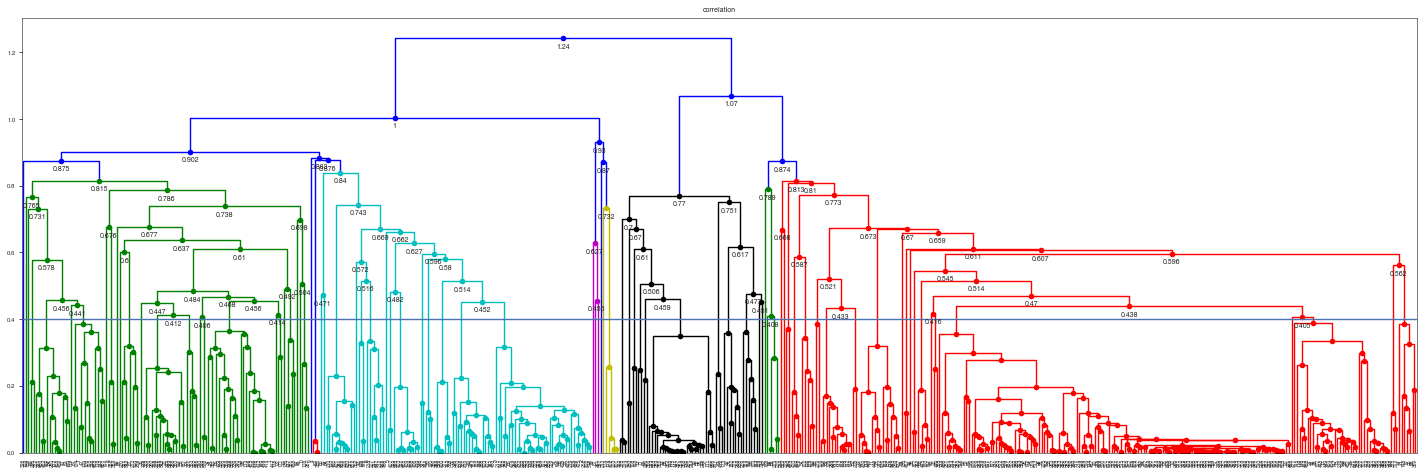

In [35]:
dists = plot_dendrogram(row_linkage, 0.4, "correlation")

In [36]:
clusters = hierarchy.fcluster(row_linkage, 0.1, criterion="distance")

In [37]:
print("n clusters: %s" % np.max(clusters))

n clusters: 223


In [38]:
cluster_map = pd.DataFrame.from_dict(dict(zip(list(corr.index), clusters)), orient="index")
cluster_map.columns = ["cluster"]
cluster_map.head()

,cluster
RUNX1,71
TFAP2A,55
Arnt,114
Ahr..Arnt,116
Ar,75


## 3. plot clustered motif heatmap

In [39]:
colors = sns.husl_palette(np.max(clusters), s=0.75)
shuffle(colors)
lut = dict(zip(range(np.min(clusters), np.max(clusters)+1), colors))
row_colors = cluster_map["cluster"].map(lut)

In [40]:
cmap = sns.cubehelix_palette(8, start=.5, light=1, dark=0.25, hue=0.9, rot=-0.75, as_cmap=True)

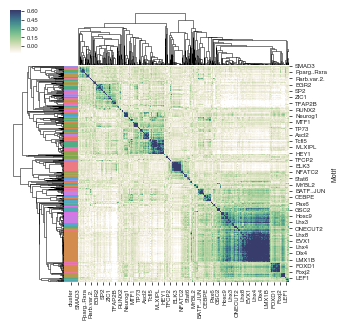

In [41]:
cg = sns.clustermap(corr, method="average", row_linkage=row_linkage, robust=True,
                    col_linkage=col_linkage, cmap=cmap, figsize=(5, 5), row_colors=row_colors,
                    linewidths=0, rasterized=True)
cg.savefig("Fig_S7A.pdf", bbox_inches="tight", dpi="figure")

## 4. re-plot # bp covered and max coverage per biotype *after* clustering
note that i sent the cluster results to marta, who re-ran her coverage scripts using them, and i re-upload them in this notebook (so in real life there is a break between the above part and the following part of this notebook)

In [42]:
cluster_cov["log_bp_covered"] = np.log(cluster_cov["numBPcovered"]+1)
cluster_cov["log_max_cov"] = np.log(cluster_cov["MaxCov"]+1)

cluster_cov_exp["log_bp_covered"] = np.log(cluster_cov_exp["numBPcovered"]+1)
cluster_cov_exp["log_max_cov"] = np.log(cluster_cov_exp["MaxCov"]+1)

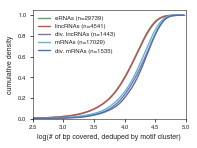

In [43]:
enh_vals = cluster_cov[cluster_cov["PromType2"] == "Enhancer"]["log_bp_covered"]
linc_vals = cluster_cov[cluster_cov["PromType2"] == "intergenic"]["log_bp_covered"]
dlnc_vals = cluster_cov[cluster_cov["PromType2"] == "div_lnc"]["log_bp_covered"]
pc_vals = cluster_cov[cluster_cov["PromType2"] == "protein_coding"]["log_bp_covered"]
dpc_vals = cluster_cov[cluster_cov["PromType2"] == "div_pc"]["log_bp_covered"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
plt.xlim((2.5,5))
fig.savefig("Fig_S7B.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
i: 1, promtype: intergenic, name: lincRNAs
i: 2, promtype: protein_coding, name: mRNAs


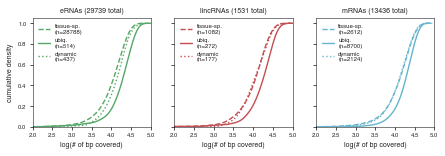

In [44]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_bp_covered"
xlabel = "log(# of bp covered)"
xlim = (2, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_S7B_biotype_split.pdf", bbox_inches="tight", dpi="figure")

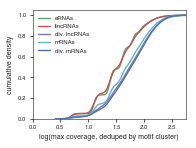

In [45]:
enh_vals = cluster_cov[cluster_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = cluster_cov[cluster_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = cluster_cov[cluster_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = cluster_cov[cluster_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = cluster_cov[cluster_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs")
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs", ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs", ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs", ax=ax)
ax.set_xlabel("log(max coverage, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
plt.xlim((0, 2.75))
fig.savefig("Fig_S7C.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
i: 1, promtype: intergenic, name: lincRNAs
i: 2, promtype: protein_coding, name: mRNAs


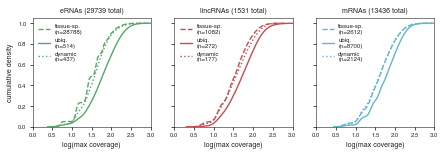

In [46]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (0, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_S7C_biotype_split.pdf", bbox_inches="tight", dpi="figure")